In [6]:
!pip install -q "openvino-dev>=2023.0.0"
!pip install -q opencv-python requests tqdm

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 60.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 36.5 MB/s eta 0:00:00


('notebook_utils.py', <http.client.HTTPMessage at 0x7f41690b8400>)

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
from openvino.runtime import Core

sys.path.append("../utils")
from notebook_utils import segmentation_map_to_image, download_file

In [9]:
from pathlib import Path

base_model_dir = Path("./model").expanduser()

model_name = "road-segmentation-adas-0001"
model_xml_name = f'{model_name}.xml'
model_bin_name = f'{model_name}.bin'

model_xml_path = base_model_dir / model_xml_name

if not model_xml_path.exists():
    model_xml_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.xml"
    model_bin_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.bin"

    download_file(model_xml_url, model_xml_name, base_model_dir)
    download_file(model_bin_url, model_bin_name, base_model_dir)
else:
    print(f'{model_name} already downloaded to {base_model_dir}')

model/road-segmentation-adas-0001.xml:   0%|          | 0.00/389k [00:00<?, ?B/s]

model/road-segmentation-adas-0001.bin:   0%|          | 0.00/720k [00:00<?, ?B/s]

In [10]:
ie = Core()

model = ie.read_model(model=model_xml_path)
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output(0)

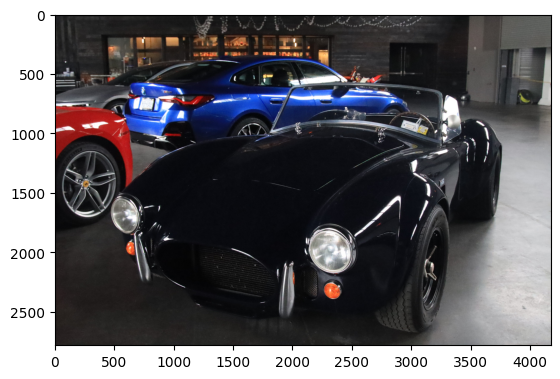

In [12]:
# The segmentation network expects images in BGR format.
image = cv2.imread("AR2A5981.jpg")

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer_ir.shape

# OpenCV resize expects the destination size as (width, height).
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(
    resized_image.transpose(2, 0, 1), 0
)
plt.imshow(rgb_image)

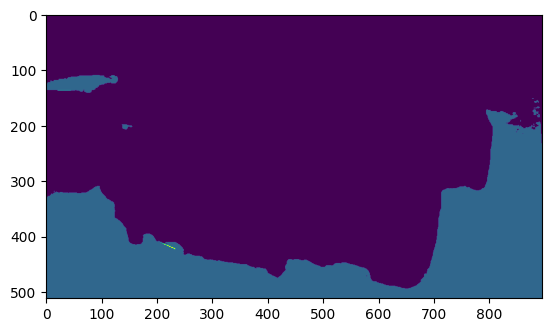

In [13]:
# Run the inference.
result = compiled_model([input_image])[output_layer_ir]

# Prepare data for visualization.
segmentation_mask = np.argmax(result, axis=1)
plt.imshow(segmentation_mask.transpose(1, 2, 0))

In [14]:
# Define colormap, each color represents a class.
colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52]])

# Define the transparency of the segmentation mask on the photo.
alpha = 0.3

# Use function from notebook_utils.py to transform mask to an RGB image.
mask = segmentation_map_to_image(segmentation_mask, colormap)
resized_mask = cv2.resize(mask, (image_w, image_h))

# Create an image with mask.
image_with_mask = cv2.addWeighted(resized_mask, alpha, rgb_image, 1 - alpha, 0)

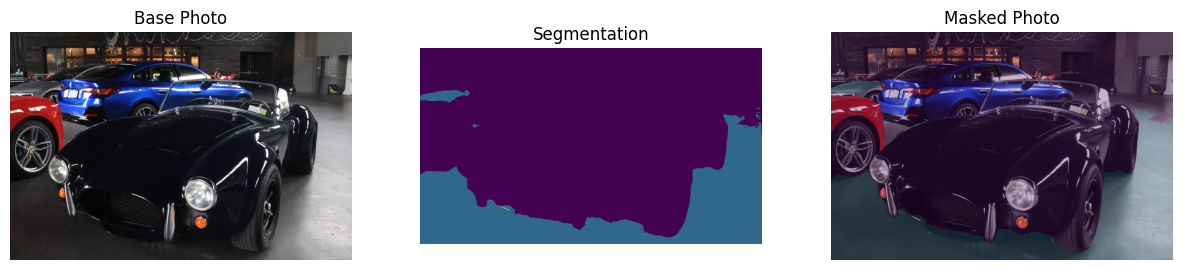

In [15]:
# Define titles with images.
data = {"Base Photo": rgb_image, "Segmentation": mask, "Masked Photo": image_with_mask}

# Create a subplot to visualize images.
fig, axs = plt.subplots(1, len(data.items()), figsize=(15, 10))

# Fill the subplot.
for ax, (name, image) in zip(axs, data.items()):
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)

# Display an image.
plt.show(fig)